# Deep learning the collisional cross sections of the peptide universe from a million experimental values

Florian Meier, Niklas D. Köhler, Andreas-David Brunner, Jean-Marc H. Wanka, Eugenia Voytik, Maximilian T. Strauss, Fabian J. Theis, Matthias Mann

Pre-print: https://doi.org/10.1101/2020.05.19.102285  
Publication: pending

revised 09/2020

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

from scipy import optimize
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [6]:
aminoacids = 'A R N D C Q E G H I L K M F P S T W Y V'.split()

In [58]:
# amino acid bulkiness
# Zimmerman J.M., Eliezer N., Simha R. J. Theor. Biol. 21:170-201(1968). 

aa_bulkiness = {
    "A": 11.500,  
    "R": 14.280, 
    "N": 12.820, 
    "D": 11.680, 
    "C": 13.460,  
    "Q": 14.450,  
    "E": 13.570,  
    "G":  3.400,  
    "H": 13.690,  
    "I": 21.400,  
    "L": 21.400,  
    "K": 15.710,  
    "M": 16.250,  
    "F": 19.800,  
    "P": 17.430,  
    "S":  9.470,  
    "T": 15.770,  
    "W": 21.670,  
    "Y": 18.030,  
    "V": 21.570  
}

def bulkiness(sequence):
    total_bulk = sum(aa_bulkiness[aa] for aa in sequence) 

    return total_bulk / len(sequence)

In [27]:
cmap = plt.get_cmap("RdYlBu")
colors = cmap(np.linspace(0, 1, num=20))
charge_col = {'2': colors[0], '3': colors[6], '4': colors[18]}

cmap2 = plt.get_cmap("YlOrRd")
cmap3 = plt.get_cmap("YlOrRd_r")

In [9]:
evidences = pd.read_csv('output/evidence_aligned.csv')
evidences.head()

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time,CCS
0,_(ac)AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,HeLa_Trp_2,9,149810.0,162.800,16,70.140,409.092528
1,_(ac)AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR_,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,3,3144.55482,1049.192220,HeLa_Trypsin_1,124,194000.0,71.438,39,3947.700,772.098100
2,_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,AAAAAAAGDSDSWDADAFSVEDPVRK,2,2634.18340,1318.098980,HeLa_Trp_2,26,6416400.0,111.750,26,94.079,573.213220
3,_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,AAAAAAAGDSDSWDADAFSVEDPVRK,3,2634.18340,879.068411,HeLa_Trp_2,30,5400600.0,42.218,26,94.841,635.000577
4,_(ac)AAAAAAAGDSDSWDADAFSVEDPVR_,AAAAAAAGDSDSWDADAFSVEDPVR,2,2506.08844,1254.051500,HeLa_Trp_2,23,245720.0,135.890,25,104.620,547.559190


In [29]:
len(evidences)

559979

In [59]:
evidences['lastAA'] = evidences['Sequence'].str[-1:]

## calculate physicochemical properties 
evidences['gravy'] = [ProteinAnalysis(seq).gravy() for seq in evidences['Sequence']]
evidences['bulkiness'] = [bulkiness(seq) for seq in evidences['Sequence']]

# Amino acids favoring secondary structures (Levitt, M. Biochemistry 17, 4277–4285 (1978))
evidences['helix_fraction'] = [(seq.count('A') + seq.count('L') + seq.count('M') + seq.count('H') + 
                                seq.count('Q') + seq.count('E'))/len(seq)  for seq in evidences['Sequence']]
evidences['sheet_fraction'] = [(seq.count('V') + seq.count('I') + seq.count('F') + seq.count('T') + 
                                seq.count('Y'))/len(seq) for seq in evidences['Sequence']]
evidences['turn_fraction'] = [(seq.count('G') + seq.count('S') + seq.count('D') + seq.count('N') + 
                               seq.count('P'))/len(seq) for seq in evidences['Sequence']]

In [60]:
evidences_trp = evidences.loc[evidences['lastAA'].str.contains('K|R')]
len(evidences_trp)

452592

In [24]:
evidences_trp_H = evidences_trp.loc[evidences_trp['Sequence'].str.count('H') > 0]

positions = []

for sequence in evidences_trp_H['Sequence']:
    pos = np.array([pos for pos, char in enumerate(sequence) if char == 'H']) 
    vector = pos - np.median(range(len(sequence)))
    relpos = sum(vector) / len(sequence) 
    positions.append(relpos)
    
evidences_trp_H['H_pos'] = positions

len(evidences_trp_H)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


171429

In [62]:
# Calculate trend line functions

CCS_fit_charge2 = evidences[evidences['Charge'] == 2] 
CCS_fit_charge3 = evidences[evidences['Charge'] == 3] 
CCS_fit_charge4 = evidences[evidences['Charge'] == 4]

def trendline_func(x, a, b):
    return a * np.power(x, b)

params_charge2, params_covariance_charge2 = optimize.curve_fit(
    trendline_func, CCS_fit_charge2['m/z'], CCS_fit_charge2['CCS'])
params_charge3, params_covariance_charge3 = optimize.curve_fit(
    trendline_func, CCS_fit_charge3['m/z'], CCS_fit_charge3['CCS'])
params_charge4, params_covariance_charge4 = optimize.curve_fit(
    trendline_func, CCS_fit_charge4['m/z'], CCS_fit_charge4['CCS'])

print('2+')
print(params_charge2, params_covariance_charge2)
print('---')
print('3+')
print(params_charge3, params_covariance_charge3)
print('---')
print('4+')
print(params_charge4, params_covariance_charge4)

2+
[15.07814883  0.49945974] [[ 2.77774921e-04 -2.73489855e-06]
 [-2.73489855e-06  2.69734056e-08]]
---
3+
[35.65345317  0.41790597] [[ 1.64798559e-02 -6.95466969e-05]
 [-6.95466969e-05  2.93893274e-07]]
---
4+
[61.1222289   0.38207705] [[ 5.95965866e-01 -1.47104958e-03]
 [-1.47104958e-03  3.63437310e-06]]


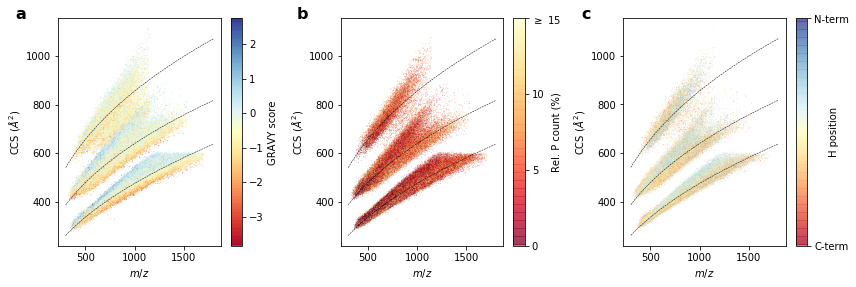

In [28]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))

# panel a
im1 = axs[0].scatter(x = evidences['m/z'], 
                    y = evidences['CCS'], 
                    c = evidences['gravy'], 
                    alpha = 0.8, s = 0.8, linewidth=0, #vmin = -1, vmax = 1,
                    cmap = cmap);

axs[0].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge2[0], params_charge2[1]), color = "black", ls = 'dashed', lw = .5)
axs[0].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge3[0], params_charge3[1]), color = "black", ls = 'dashed', lw = .5)
axs[0].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge4[0], params_charge4[1]), color = "black", ls = 'dashed', lw = .5)
    
axs[0].set_ylabel('CCS ($\AA^2$)')
axs[0].set_xlabel('$\it{m/z}$')
    
axs[0].text(-0.2, 1.05, "a", transform=axs[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im1, ax = axs[0])
cb.set_label('GRAVY score')   


# panel b
im2 = axs[1].scatter(x = evidences_trp['m/z'], 
                    y = evidences_trp['CCS'], 
                    c = (evidences_trp['Sequence'].str.count('P') / evidences_trp['Sequence'].str.len() * 100), 
                    alpha = 0.5, s = 0.5, linewidth=0, vmin = 0, vmax = 15,
                    cmap = cmap3)


axs[1].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge2[0], params_charge2[1]), color = "black", ls = 'dashed', lw = .5)
axs[1].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge3[0], params_charge3[1]), color = "black", ls = 'dashed', lw = .5)
axs[1].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge4[0], params_charge4[1]), color = "black", ls = 'dashed', lw = .5)
    
axs[1].set_ylabel('CCS ($\AA^2$)')
axs[1].set_xlabel('$\it{m/z}$')
    
axs[1].text(-0.2, 1.05, "b", transform=axs[1].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im2, ax = axs[1])
cb.set_ticks([0,5,10,15])
cb.set_ticklabels(['0', '5', '10', '$\geq$ 15'])
cb.set_label('Rel. P count (%)', labelpad = -10)   


# panel c
im3 = axs[2].scatter(x = evidences_trp_H['m/z'], 
                    y = evidences_trp_H['CCS'], 
                    c = evidences_trp_H['H_pos'], 
                    alpha = 0.5, s = 0.5, linewidth=0, vmin = -1, vmax = 1,
                    cmap = cmap)


axs[2].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge2[0], params_charge2[1]), color = "black", ls = 'dashed', lw = .5)
axs[2].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge3[0], params_charge3[1]), color = "black", ls = 'dashed', lw = .5)
axs[2].plot(np.arange(300,1800,1), trendline_func(
    np.arange(300,1800,1), params_charge4[0], params_charge4[1]), color = "black", ls = 'dashed', lw = .5)
    
axs[2].set_ylabel('CCS ($\AA^2$)')
axs[2].set_xlabel('$\it{m/z}$')
    
axs[2].text(-0.2, 1.05, "c", transform=axs[2].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im3, ax = axs[2])
cb.set_ticks([-1,1])
cb.set_ticklabels(['C-term', 'N-term'])
cb.set_label('H position', labelpad = -20)  
    
plt.tight_layout()
plt.savefig('figures/Figure3.jpg')
plt.show();    

<b>Figure 3. A global view on peptide cross sections.</b> <b>a,</b> Mass-to-charge vs. collisional cross section distribution of all peptides in this study colored by the GRAVY hydrophobicity index (n = 559,979). </b> <b>b,</b> Subset of peptides with C-terminal arginine or lysine colored by the fraction of prolines in the linear sequence (n = 452,592). </b> <b>c,</b> Histidine-containing peptides of b colored by the relative position of histidine (n = 171,429). Trend lines (dashed) are fitted to the overall peptide distribution to visualize the correlation of ion mass and mobility in each charge state.

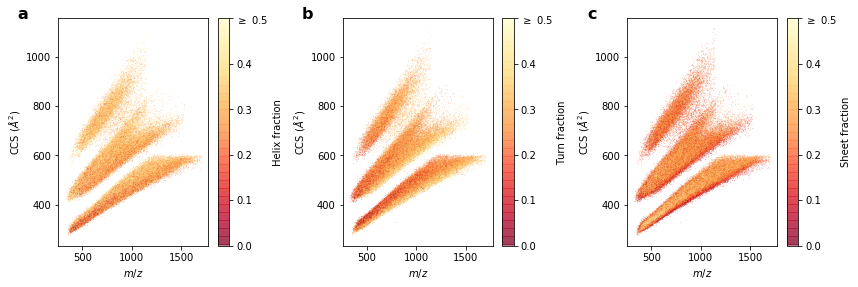

In [31]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))

# panel a
im1 = axs[0].scatter(x = evidences_trp['m/z'], 
                    y = evidences_trp['CCS'], 
                    c = evidences_trp['helix_fraction'], 
                    alpha = 0.5, s = 0.5, linewidth=0, vmin = 0, vmax = 0.5,
                    cmap = cmap3);
    
axs[0].set_ylabel('CCS ($\AA^2$)')
axs[0].set_xlabel('$\it{m/z}$')
    
axs[0].text(-0.2, 1.05, "a", transform=axs[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im1, ax = axs[0])
cb.set_ticks([0,0.1,0.2,0.3, 0.4, 0.5])
cb.set_ticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '$\geq$ 0.5'])
cb.set_label('Helix fraction')  


# panel b
im2 = axs[1].scatter(x = evidences_trp['m/z'], 
                    y = evidences_trp['CCS'], 
                    c = evidences_trp['turn_fraction'],  
                    alpha = 0.5, s = 0.5, linewidth=0, vmin = 0, vmax = 0.5,
                    cmap = cmap3)
    
axs[1].set_ylabel('CCS ($\AA^2$)')
axs[1].set_xlabel('$\it{m/z}$')
    
axs[1].text(-0.2, 1.05, "b", transform=axs[1].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im2, ax = axs[1])
cb.set_ticks([0,0.1,0.2,0.3, 0.4, 0.5])
cb.set_ticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '$\geq$ 0.5'])
cb.set_label('Turn fraction')


# panel c
im3 = axs[2].scatter(x = evidences_trp['m/z'], 
                    y = evidences_trp['CCS'], 
                    c = evidences_trp['sheet_fraction'], 
                    alpha = 0.5, s = 0.5, linewidth=0, vmin = 0, vmax = 0.5,
                    cmap = cmap3)
    
axs[2].set_ylabel('CCS ($\AA^2$)')
axs[2].set_xlabel('$\it{m/z}$')
    
axs[2].text(-0.2, 1.05, "c", transform=axs[2].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im3, ax = axs[2])
cb.set_ticks([0,0.1,0.2,0.3, 0.4, 0.5])
cb.set_ticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '$\geq$ 0.5'])

cb.set_label('Sheet fraction')  
     
plt.tight_layout()
plt.savefig('figures/Figure_S3.png')
plt.show(); 

<b>Supplementary Figure 5.</b> Fraction of amino acids favoring <b>a,</b> helical (A, L, M, H, Q, E), <b>b,</b> turn (V, I, F, T, Y) and <b>c,</b> sheet (G, S, D, N, P) secondary structures according to Levitt 1978.

### Comparison LysC vs. LysN

In [33]:
evidences['firstAA'] = evidences['Sequence'].str[:1]
evidences['lastAA'] = evidences['Sequence'].str[-1:]

evidence_subset_LysC = evidences[evidences['lastAA'].isin(['K'])]
evidence_subset_LysN = evidences[evidences['firstAA'].isin(['K'])]

In [34]:
mod_seq_lysC = []
mod_seq_lysN = []
seq_lysC = []
seq_lysN = []
internal_seq = []
CCS_lysC = []
CCS_lysN = []
deltas = []
Mass = []
mz = []

for index, row in evidence_subset_LysC.iterrows():
    
    internal_sequence = row['Modified sequence'][1:-2]            
    tmp = evidence_subset_LysN.loc[evidence_subset_LysN['Modified sequence'].str[2:-1] == internal_sequence]

    if(len(tmp) > 0):
            
        for i, sequence in enumerate(tmp['Sequence']):
            if ( (row['Charge'] == tmp.iloc[i]['Charge'])):

                mod_seq_lysC.append(row['Modified sequence'])
                mod_seq_lysN.append(tmp.iloc[i]['Modified sequence'])
                seq_lysC.append(row['Sequence'])
                seq_lysN.append(tmp.iloc[i]['Sequence'])
                internal_seq.append(internal_sequence)

                CCS_lysC.append(row['CCS'])
                CCS_lysN.append(tmp.iloc[i]['CCS'])

                Mass.append(row['Mass'])
                mz.append(row['m/z'])

                deltas.append(row['CCS'] - tmp.iloc[i]['CCS'])
                                           
lysc_lysn = pd.DataFrame()
lysc_lysn['mod_seq_lysC'] = mod_seq_lysC
lysc_lysn['mod_seq_lysN'] = mod_seq_lysN
lysc_lysn['seq_lysC'] = seq_lysC
lysc_lysn['seq_lysN'] = seq_lysN
lysc_lysn['internal_seq'] = internal_seq
lysc_lysn['CCS_lysC'] = CCS_lysC
lysc_lysn['CCS_lysN'] = CCS_lysN
lysc_lysn['deltas'] = deltas
lysc_lysn['Mass'] = Mass
lysc_lysn['mz'] = mz

lysc_lysn.to_csv('output/peptides_LysN_LysC.csv');
print(len(deltas))

60081


In [36]:
lysc_lysn['charge'] = np.rint(lysc_lysn['Mass']/lysc_lysn['mz'])

In [40]:
# Median relative shift
((lysc_lysn['CCS_lysC']-lysc_lysn['CCS_lysN'])/lysc_lysn['CCS_lysC']*100).median()

1.1815963394830509

In [41]:
lysc_lysn_charge2 = lysc_lysn[lysc_lysn['charge'] == 2] 
lysc_lysn_charge3 = lysc_lysn[lysc_lysn['charge'] == 3] 
lysc_lysn_charge4 = lysc_lysn[lysc_lysn['charge'] == 4] 

len(lysc_lysn_charge2), len(lysc_lysn_charge3), len(lysc_lysn_charge4)

(43463, 14388, 2230)

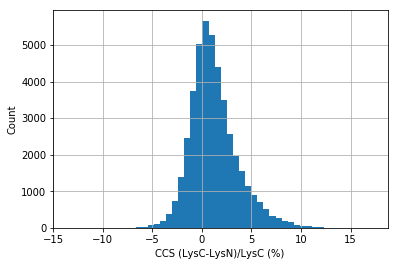

In [38]:
((lysc_lysn_charge2['CCS_lysC']-lysc_lysn_charge2['CCS_lysN'])/lysc_lysn_charge2['CCS_lysC']*100).hist(bins = 50)

plt.xlabel('CCS (LysC-LysN)/LysC (%) ')
plt.ylabel('Count');

plt.savefig("figures/Suppl_Fig_5c.jpg")

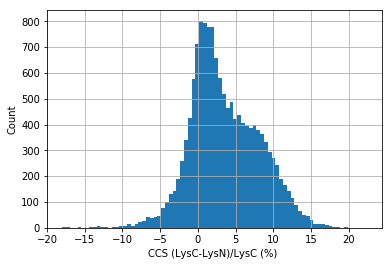

In [39]:
((lysc_lysn_charge3['CCS_lysC']-lysc_lysn_charge3['CCS_lysN'])/lysc_lysn_charge3['CCS_lysC']*100).hist(bins = 80)

plt.xlabel('CCS (LysC-LysN)/LysC (%) ')
plt.ylabel('Count');

plt.savefig("figures/Suppl_Fig_5d.png")

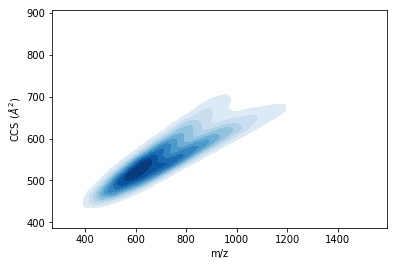

In [52]:
sns.kdeplot(evidence_subset_LysC.loc[evidence_subset_LysC['Charge'] == 3]['m/z'], 
            evidence_subset_LysC.loc[evidence_subset_LysC['Charge'] == 3]['CCS'], 
            cmap="Blues", shade=True, shade_lowest=False)
plt.xlabel('m/z')
plt.ylabel('CCS ($\AA^2$)')

plt.savefig("figures/Suppl_Fig_5a_charge3.png");

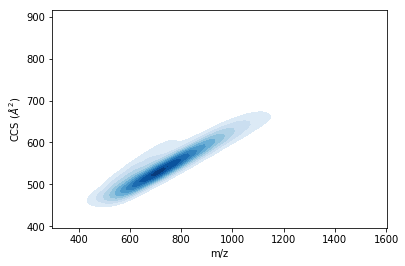

In [53]:
sns.kdeplot(evidence_subset_LysN.loc[evidence_subset_LysN['Charge'] == 3]['m/z'], 
            evidence_subset_LysN.loc[evidence_subset_LysN['Charge'] == 3]['CCS'], 
            cmap="Blues", shade=True, shade_lowest=False)
plt.xlabel('m/z')
plt.ylabel('CCS ($\AA^2$)')

plt.savefig("figures/Suppl_Fig_5b_charge3.png");

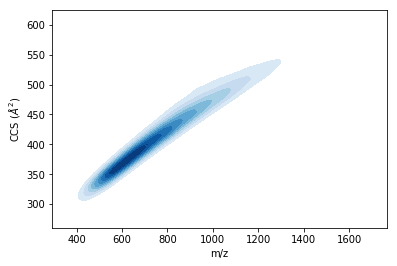

In [54]:
sns.kdeplot(evidence_subset_LysC.loc[evidence_subset_LysC['Charge'] == 2]['m/z'], 
            evidence_subset_LysC.loc[evidence_subset_LysC['Charge'] == 2]['CCS'], 
            cmap="Blues", shade=True, shade_lowest=False)
plt.xlabel('m/z')
plt.ylabel('CCS ($\AA^2$)')

plt.savefig("figures/Suppl_Fig_5a_charge2.png");

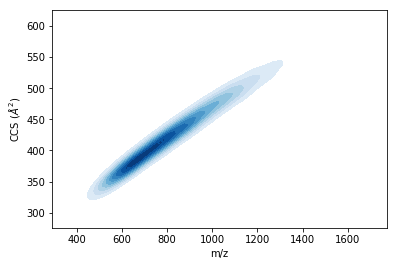

In [55]:
sns.kdeplot(evidence_subset_LysN.loc[evidence_subset_LysN['Charge'] == 2]['m/z'], 
            evidence_subset_LysN.loc[evidence_subset_LysN['Charge'] == 2]['CCS'], 
            cmap="Blues", shade=True, shade_lowest=False)
plt.xlabel('m/z')
plt.ylabel('CCS ($\AA^2$)')

plt.savefig("figures/Suppl_Fig_5b_charge2.png");

### Comparison bulkiness vs. hydrophobicity

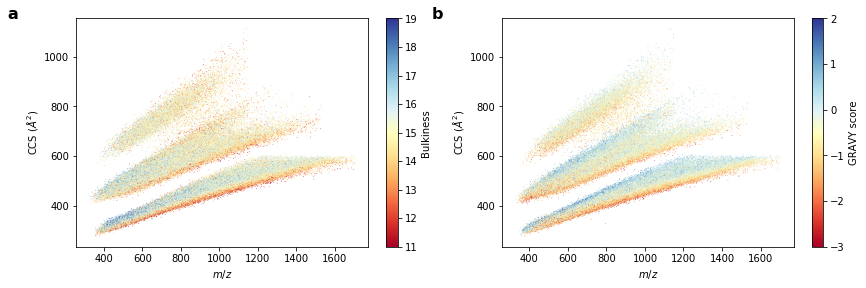

In [61]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))

# panel a
im1 = axs[0].scatter(x = evidences_trp['m/z'], 
                    y = evidences_trp['CCS'], 
                    c = evidences_trp['bulkiness'], 
                    alpha = 1, s = 0.5, linewidth=0, vmin = 11, vmax = 19,
                    cmap = cmap);
    
axs[0].set_ylabel('CCS ($\AA^2$)')
axs[0].set_xlabel('$\it{m/z}$')
    
axs[0].text(-0.2, 1.05, "a", transform=axs[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im1, ax = axs[0])
cb.set_label('Bulkiness') 

# panel b
im2 = axs[1].scatter(x = evidences_trp['m/z'], 
                    y = evidences_trp['CCS'], 
                    c = evidences_trp['gravy'], 
                    alpha = 1, s = 0.5, linewidth=0, vmin = -3, vmax = 2,
                    cmap = cmap);
    
axs[1].set_ylabel('CCS ($\AA^2$)')
axs[1].set_xlabel('$\it{m/z}$')
    
axs[1].text(-0.2, 1.05, "b", transform=axs[1].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
cb = fig.colorbar(im2, ax = axs[1])
cb.set_label('GRAVY score')  

   
plt.tight_layout()
plt.savefig('figures/revision_bulk_hydrophob.png')
plt.show();   

In [125]:
# define quantiles for deviation from trend line

CCS_fit_charge2['deltaFit'] = (CCS_fit_charge2['CCS'] - trendline_func(
    CCS_fit_charge2['m/z'], params_charge2[0], params_charge2[1])) / trendline_func(
    CCS_fit_charge2['m/z'], params_charge2[0], params_charge2[1])

q1 = CCS_fit_charge2['deltaFit'].quantile(0.20)
q2 = CCS_fit_charge2['deltaFit'].quantile(0.40)
q3 = CCS_fit_charge2['deltaFit'].quantile(0.60)
q4 = CCS_fit_charge2['deltaFit'].quantile(0.80)

CCS_fit_charge2.loc[CCS_fit_charge2['deltaFit'] < q1, 'quantile'] = 1
CCS_fit_charge2.loc[(CCS_fit_charge2['deltaFit'] >= q1) & (CCS_fit_charge2['deltaFit'] < q2), 'quantile'] = 2
CCS_fit_charge2.loc[(CCS_fit_charge2['deltaFit'] >= q2) & (CCS_fit_charge2['deltaFit'] < q3), 'quantile'] = 3
CCS_fit_charge2.loc[(CCS_fit_charge2['deltaFit'] >= q3) & (CCS_fit_charge2['deltaFit'] < q4), 'quantile'] = 4
CCS_fit_charge2.loc[(CCS_fit_charge2['deltaFit'] >= q4), 'quantile'] = 5


CCS_fit_charge3['deltaFit'] = (CCS_fit_charge3['CCS'] - trendline_func(
    CCS_fit_charge3['m/z'], params_charge3[0], params_charge3[1])) / trendline_func(
    CCS_fit_charge3['m/z'], params_charge3[0], params_charge3[1])

q1 = CCS_fit_charge3['deltaFit'].quantile(0.20)
q2 = CCS_fit_charge3['deltaFit'].quantile(0.40)
q3 = CCS_fit_charge3['deltaFit'].quantile(0.60)
q4 = CCS_fit_charge3['deltaFit'].quantile(0.80)

CCS_fit_charge3.loc[CCS_fit_charge3['deltaFit'] < q1, 'quantile'] = 1
CCS_fit_charge3.loc[(CCS_fit_charge3['deltaFit'] >= q1) & (CCS_fit_charge3['deltaFit'] < q2), 'quantile'] = 2
CCS_fit_charge3.loc[(CCS_fit_charge3['deltaFit'] >= q2) & (CCS_fit_charge3['deltaFit'] < q3), 'quantile'] = 3
CCS_fit_charge3.loc[(CCS_fit_charge3['deltaFit'] >= q3) & (CCS_fit_charge3['deltaFit'] < q4), 'quantile'] = 4
CCS_fit_charge3.loc[(CCS_fit_charge3['deltaFit'] >= q4), 'quantile'] = 5

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [107]:
from matplotlib.colors import ListedColormap

In [119]:
cmap = ListedColormap(sns.color_palette('tab10', n_colors = 5))

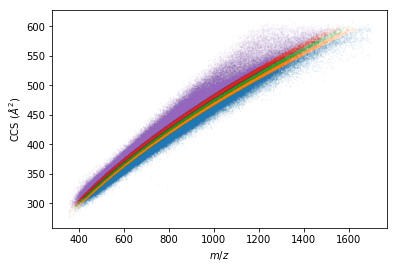

In [126]:
plt.scatter(CCS_fit_charge2['m/z'], CCS_fit_charge2['CCS'], s = .1, alpha = .1, c=CCS_fit_charge2['quantile'], cmap = cmap)

plt.ylabel('CCS ($\AA^2$)')
plt.xlabel('$\it{m/z}$')

plt.savefig('figures/Supplementary_Figure_quantiles_a.jpg');

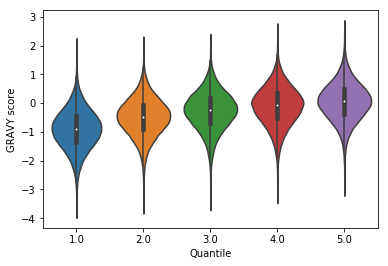

In [133]:
sns.violinplot(y = 'gravy', x = 'quantile', data = CCS_fit_charge2)

plt.ylabel('GRAVY score')
plt.xlabel('Quantile')

plt.savefig('figures/Supplementary_Figure_quantiles_b.jpg')

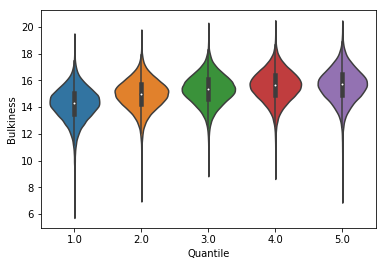

In [134]:
sns.violinplot(y = 'bulkiness', x = 'quantile', data = CCS_fit_charge2)

plt.ylabel('Bulkiness')
plt.xlabel('Quantile')

plt.savefig('figures/Supplementary_Figure_quantiles_c.jpg')

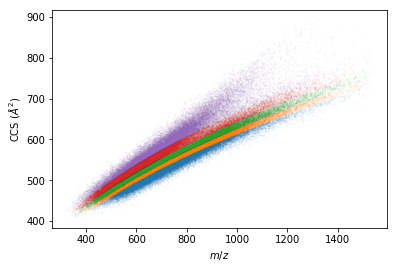

In [130]:
plt.scatter(CCS_fit_charge3['m/z'], CCS_fit_charge3['CCS'], s = .1, alpha = .1, c=CCS_fit_charge3['quantile'], cmap = cmap)
plt.ylabel('CCS ($\AA^2$)')
plt.xlabel('$\it{m/z}$')

plt.savefig('figures/Supplementary_Figure_quantiles_d.jpg')

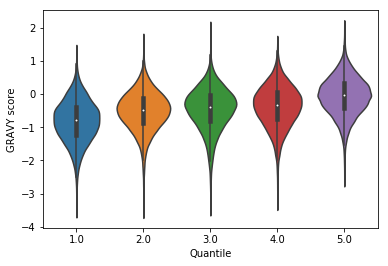

In [135]:
sns.violinplot(y = 'gravy', x = 'quantile', data = CCS_fit_charge3)

plt.ylabel('GRAVY score')
plt.xlabel('Quantile')

plt.savefig('figures/Supplementary_Figure_quantiles_e.jpg')

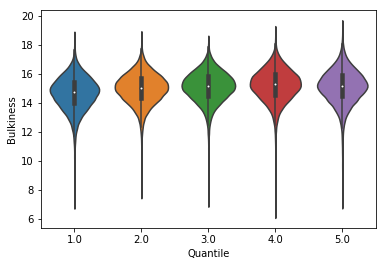

In [136]:
sns.violinplot(y = 'bulkiness', x = 'quantile', data = CCS_fit_charge3)

plt.ylabel('Bulkiness')
plt.xlabel('Quantile')

plt.savefig('figures/Supplementary_Figure_quantiles_f.jpg')